# Semantic segmentation of Biomedical images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import zipfile

plt.style.use('ggplot')

In [ ]:
drive_folder = '/content/drive/MyDrive'
folder = drive_folder + '/A3_DL4IA/Ex2'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Functions needed in this notebook

In [ ]:
def extract_files(file_name):
    """Extract the input zip file in the current directory."""
    
    with zipfile.ZipFile(file_name, 'r') as zip:
        zip.extractall()

In [ ]:
def load_warwick():
    """Loads the WARWICK dataset from png images."""

    # Create list for test set
    test_images = []
    test_labels = []    
    
    for image_path in glob.glob("WARWICK/Test/image_*.png"):
      num = image_path[len(image_path) - 6: len(image_path) - 4]
      image = imageio.imread(image_path)
      label = imageio.imread(f"WARWICK/Test/label_{num}.png")
      test_images.append(image)
      test_labels.append(label)
            
    # Create list for training set
    train_images = []
    train_labels = []    
    
    for image_path in glob.glob("WARWICK/Train/image_*.png"):
      num = image_path[len(image_path) - 6: len(image_path) - 4]
      image = imageio.imread(image_path)
      label = imageio.imread(f"WARWICK/Train/label_{num}.png")
      train_images.append(image)
      train_labels.append(label)

    X_train = np.array(train_images)/255.0
    X_test = np.array(test_images)/255.0        
    Y_test = np.array(test_labels)/255.0
    Y_train = np.array(train_labels)/255.0

    return X_train, Y_train, X_test, Y_test

In [ ]:
class MyWARWICKDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.data = self.data.permute(0,3,1,2) # In PyTorch, the channel axis is on the second dimension
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
def compute_DSC_score(prediction, truth, average=True):
  """Computes the DSC score based on the network's output (prediction) and the ground truth annotation (truth) of the images.
  
  Args:
    prediction (tensor): network's linear output (before softmax), of shape torch.Size([batch_size, 2, 128, 128])
    truth (tensor): the ground truth annotation of the images, of shape  torch.Size([batch_size, 128, 128])
    average (bool): if True, computes the average DSC score of all images, otherwise computes the DSC score for each example
  """

  prediction = nn.Softmax(dim=1)(prediction)
  segmentation_map = torch.argmax(prediction, dim=1)
  numerator = 2 * torch.sum(segmentation_map * truth, dim=(1,2))
  denominator = torch.sum(segmentation_map, dim=(1,2)) + torch.sum(truth, dim=(1,2))
  division = torch.div(numerator, denominator)
  if average:
    DSC_score = torch.mean(division)
  else:
    DSC_score = division
  return DSC_score

In [ ]:
def train_model(model, loss_criterion, performance_metric, optimizer, train_loader, X_test, Y_test, num_epochs, plot_result=False):
  train_losses = list()
  train_scores = list()
  test_losses = list()
  test_scores = list()

  for epoch in range(num_epochs):
      train_losses_epoch = list()
      train_scores_epoch = list()

      for batch in train_loader:
          x_train, y_train = batch[0].to(device), batch[1].to(device)
          
          model.zero_grad()

          # 1. Forward propagation
          output = model(x_train)

          # 2. Compute loss and score on current mini-batch
          loss = loss_criterion(output, y_train)

          train_loss = loss.item()
          train_losses_epoch.append(train_loss)
          train_score = performance_metric(output, y_train).item()
          train_scores_epoch.append(train_score)

          # 3. Backpropagation
          loss.backward()  

          # 4. Update parameters
          optimizer.step()
      
      # Train cost and score 
      train_loss = np.mean(train_losses_epoch)
      train_losses.append(train_loss)
      train_score = np.mean(train_scores_epoch)
      train_scores.append(train_score)

      # Test cost and score
      with torch.no_grad():
          output = model(X_test)

          test_loss = loss_criterion(output, Y_test).item()
          test_losses.append(test_loss)
          test_score = performance_metric(output, Y_test).item()
          test_scores.append(test_score)
      
      if plot_result and epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  loss: {train_loss:.4f}, score: {train_score:.4f}")
        print(f"  test_loss: {test_loss:.4f}, test_score: {test_score:.4f}\n")

        
  print("FINAL")
  print(f'  loss: {train_loss:.4f}, score: {train_score:.4f}')
  print(f'  test_loss: {test_loss:.4f}, test_score: {test_score:.4f}')

  return train_losses, train_scores, test_losses, test_scores

In [ ]:
def plot_result(metric, train_res, test_res, model_name, learning_rate, num_epochs, optim="sgd", batch_size=32, save_folder=None):
    x_axis = range(num_epochs)
    plt.figure(figsize=(12,7))
    plt.plot(x_axis, test_res, label="Test data", zorder=10)
    plt.plot(x_axis, train_res, label="Training data", zorder=0)
    plt.ylabel(metric)
    plt.xlabel("Epochs")
    plt.title(f"{model_name} {metric} over {num_epochs} epochs")
    plt.legend()
    if save_folder:
      plt.savefig(f'{save_folder}/{model_name}_{metric}_{train_res[-1]:.4f}_test_{metric}_{test_res[-1]:.4f}_ep_{num_epochs}_{optim}_lr_{learning_rate}_bs_{batch_size}.png')

## Load the data

In [ ]:
extract_files(drive_folder + "/WARWICK.zip")

In [ ]:
X_train_numpy, Y_train_numpy, X_test_numpy, Y_test_numpy = load_warwick()

In [ ]:
print(X_train_numpy.shape, Y_train_numpy.shape, X_test_numpy.shape, Y_test_numpy.shape)

(85, 128, 128, 3) (85, 128, 128) (60, 128, 128, 3) (60, 128, 128)


In [ ]:
# Training set
train_set = MyWARWICKDataset(X_train_numpy, Y_train_numpy)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
X_train, Y_train = train_set[:]

# Test set
test_set = MyWARWICKDataset(X_test_numpy, Y_test_numpy)
X_test, Y_test = test_set[:]
X_test = X_test.to(device)
Y_test = Y_test.to(device)

## Exercise 2.1

### Create the model

In [ ]:
class FCN(nn.Module):
  def __init__(self, in_channels=3, out_channels=2):
    super(FCN, self).__init__()

    self.model = nn.Sequential(
      nn.Conv2d(in_channels, out_channels=8, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
      nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
      nn.Conv2d(8, out_channels, kernel_size=1), # classification layer
    )

  def forward(self, x):
    x = self.model(x)
    return x

### Train the model

In [ ]:
# Instantiate the model, loss criterion and optimizer
model = FCN()
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using the train_model function in utils.py
train_losses, train_scores, test_losses, test_scores = train_model(model, loss_criterion, compute_DSC_score, optimizer, train_loader, X_test, Y_test, num_epochs=100, plot_result=True)

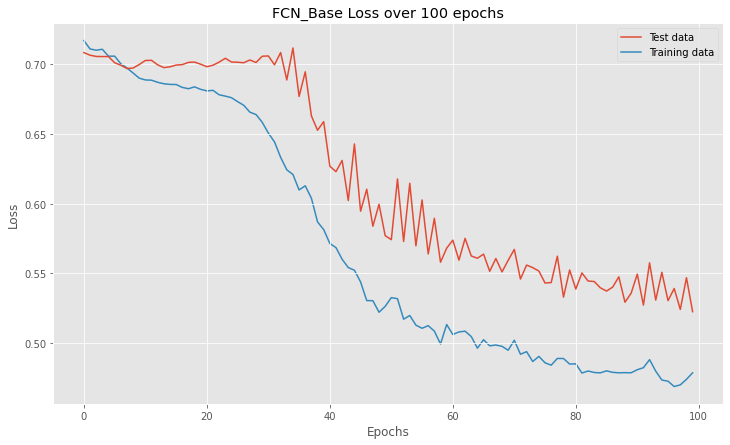

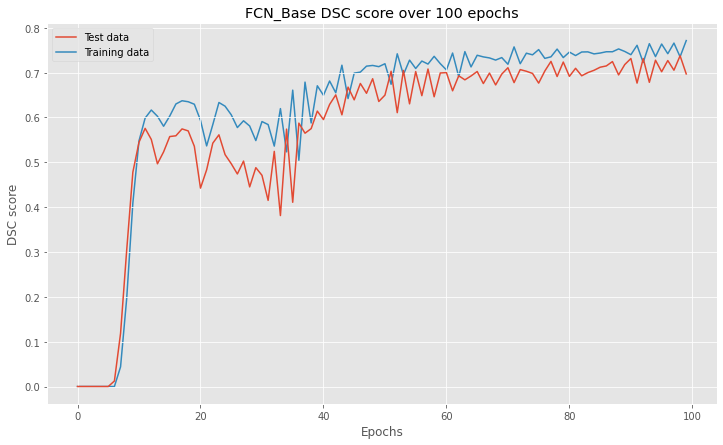

In [ ]:
model_name = "FCN_Base"
plot_result("Loss", train_losses, test_losses, model_name, learning_rate=0.001, num_epochs=100, optim="adam", batch_size=32, save_folder=folder)
plot_result("DSC score", train_scores, test_scores, model_name, learning_rate=0.001, num_epochs=100, optim="adam", batch_size=32, save_folder=folder)

In [ ]:
# Save model 
torch.save({
            'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_scores[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_scores[-1]
            }, f"{folder}/models/{model_name}")

### Results

We now want to visually inspect one of the cases (in the test-set) where the network did not perform well in terms of the evaluation metric.

In [ ]:
def plot_images(images, title, savefig_title=None):
  legends = ["Image", "Target", "Prediction"]
  fig, axs = plt.subplots(1, 3, figsize=(10, 4))
  axs = axs.flatten()
  for img, ax, subtitle in zip(images, axs, legends):
      ax.imshow(img, cmap='gray')
      ax.set_title(subtitle)
  plt.suptitle(title)
  if savefig_title:
    fig.savefig(savefig_title)
  plt.show()

In [ ]:
predictions = model(X_test)

In [ ]:
scores = compute_DSC_score(predictions, Y_test, average=False)
scores

tensor([0.3755, 0.3708, 0.5407, 0.6917, 0.8186, 0.7790, 0.4080, 0.7057, 0.6667,
        0.4264, 0.7962, 0.5813, 0.6346, 0.8815, 0.7821, 0.7109, 0.7775, 0.8810,
        0.8025, 0.7805, 0.5072, 0.4169, 0.7008, 0.6093, 0.8929, 0.8193, 0.8078,
        0.7654, 0.5479, 0.5197, 0.8528, 0.8101, 0.7625, 0.7046, 0.8257, 0.5361,
        0.7748, 0.8881, 0.5374, 0.7484, 0.7841, 0.7678, 0.8254, 0.6839, 0.7133,
        0.5182, 0.8054, 0.8430, 0.8895, 0.3704, 0.7904, 0.7566, 0.8677, 0.5748,
        0.7854, 0.7117, 0.7271, 0.6414, 0.7268, 0.6071])

In [ ]:
smallest_k_scores, smallest_k_scores_idx = torch.topk(scores, 3, largest=False)

In [ ]:
bad_predictions = predictions[smallest_k_scores_idx]
bad_seg_map = torch.argmax(bad_predictions, dim=1)

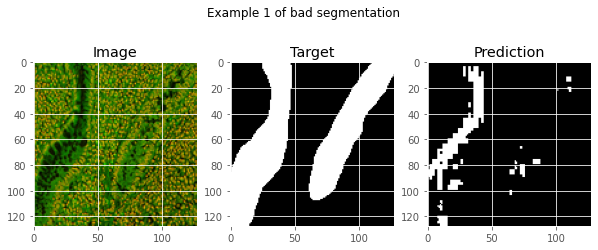

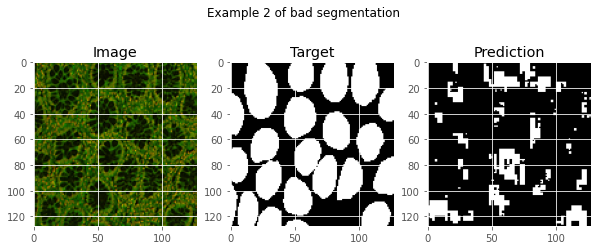

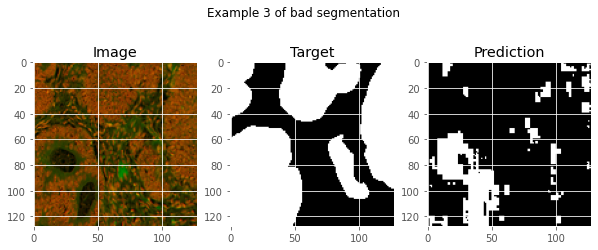

In [ ]:
for k, idx in enumerate(smallest_k_scores_idx):
  images = [X_test[idx].permute(1,2,0), Y_test[idx], bad_seg_map[k]]
  plot_images(images, f"Example {k+1} of bad segmentation", f"{folder}/FCN_Base_ex_{k+1}_bad_segmentation.png")

In [ ]:
largest_k_scores, largest_k_scores_idx = torch.topk(scores, 3)
good_predictions = predictions[largest_k_scores_idx]
good_seg_map = torch.argmax(good_predictions, dim=1)

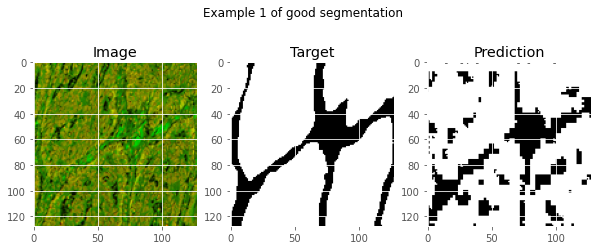

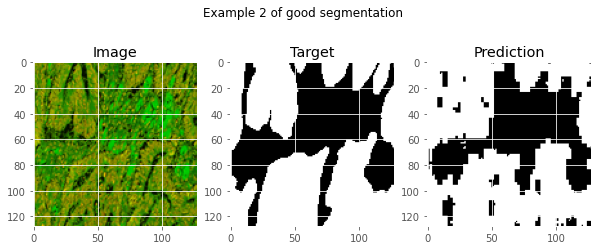

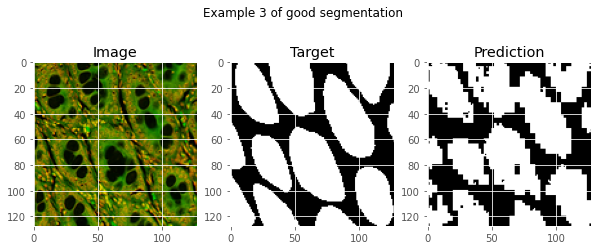

In [ ]:
for k, idx in enumerate(largest_k_scores_idx):
  images = [X_test[idx].permute(1,2,0), Y_test[idx], good_seg_map[k]]
  plot_images(images, f"Example {k+1} of good segmentation", f"{folder}/FCN_Base_ex_{k+1}_good_segmentation.png")

## Exercise 2.2

#### Changing the architecture

In [ ]:
class FCN2(nn.Module):
  def __init__(self, in_channels=3, out_channels=2):
    super(FCN2, self).__init__()

    self.model = nn.Sequential(
      nn.Conv2d(in_channels, out_channels=8, kernel_size=3, stride=1, padding=1), 
      nn.BatchNorm2d(8),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), 

      nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), 
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
      nn.BatchNorm2d(32),
      nn.ReLU(),

      nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
      nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),

      nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
      nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(8),
      nn.ReLU(),

      nn.Conv2d(8, out_channels, kernel_size=1), # classification layer
    
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
model = FCN2()
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_scores, test_losses, test_scores = train_model(model, loss_criterion, compute_DSC_score, optimizer, train_loader, X_test, Y_test, num_epochs=100, plot_result=True)

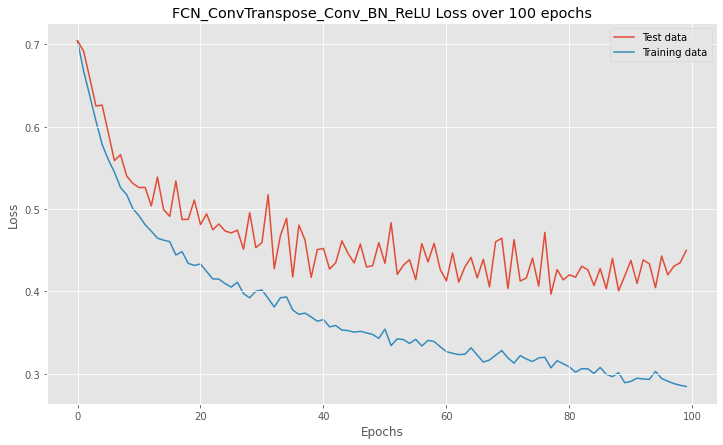

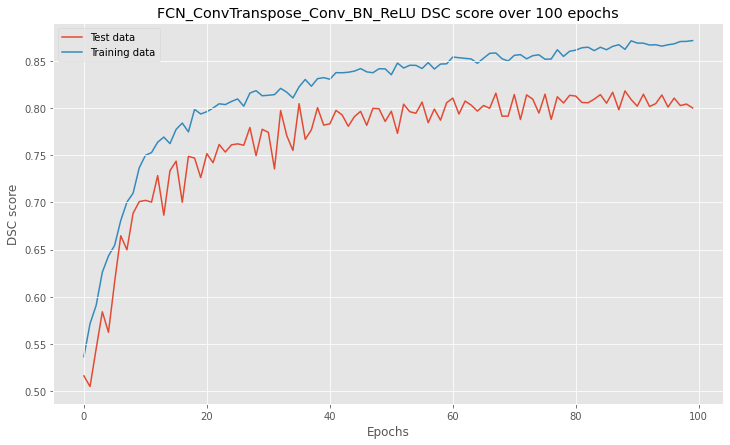

In [ ]:
model_name = "FCN_ConvTranspose_Conv_BN_ReLU"
plot_result("Loss", train_losses, test_losses, model_name, learning_rate=0.001, num_epochs=100, optim="adam", batch_size=32, save_folder=folder)
plot_result("DSC score", train_scores, test_scores, model_name, learning_rate=0.001, num_epochs=100, optim="adam", batch_size=32, save_folder=folder)

In [ ]:
# Save model 
torch.save({
            'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_scores[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_scores[-1]
            }, f"{folder}/models/{model_name}")

#### Data Augmentation

In [ ]:
def data_augment():
    train_images = []
    train_labels = []   
    train_images_augmented = []
    train_labels_augmented = [] 
    
    for image_path in glob.glob("WARWICK/Train/image_*.png"):
      num = image_path[len(image_path) - 6: len(image_path) - 4]
      image = imageio.imread(image_path)
      label = imageio.imread(f"WARWICK/Train/label_{num}.png")
      train_images.append(image)
      train_labels.append(label)

    for image, label in zip(train_images, train_labels):
      # Original
      train_images_augmented.append(image)
      train_labels_augmented.append(label)
      
      # Fliplr
      train_images_augmented.append(np.fliplr(image))
      train_labels_augmented.append(np.fliplr(label))

      # Flipud
      train_images_augmented.append(np.flipud(image))
      train_labels_augmented.append(np.flipud(label))

    X_train_augmented = np.array(train_images_augmented)/255.0
    Y_train_augmented = np.array(train_labels_augmented)/255.0
    
    return X_train_augmented, Y_train_augmented

In [ ]:
X_train_augmented, Y_train_augmented = data_augment()

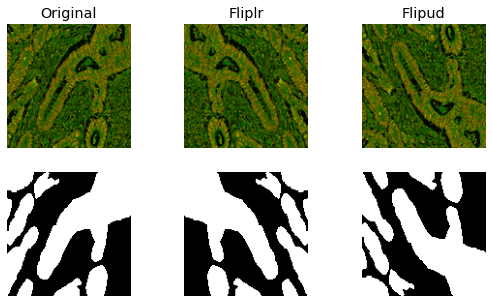

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(9,5))
legends = ["Original", "Fliplr", "Flipud"]
for i in range(3):
    ax[0][i].imshow(X_train_augmented[i+3], cmap="gray")
    ax[1][i].imshow(Y_train_augmented[i+3], cmap="gray")
    ax[0][i].axis('off')
    ax[1][i].axis('off')
    ax[0][i].set_title(legends[i])
plt.savefig(f"{folder}/data_aug_examples.png")

In [ ]:
print(X_train_augmented.shape, Y_train_augmented.shape)

(255, 128, 128, 3) (255, 128, 128)


In [ ]:
# Training set
train_set_aug = MyWARWICKDataset(X_train_augmented, Y_train_augmented)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)

In [ ]:
model = FCN2()
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_scores, test_losses, test_scores = train_model(model, loss_criterion, compute_DSC_score, optimizer, train_loader_aug, X_test, Y_test, num_epochs=100, plot_result=True)

Epoch [1/100]
  loss: 0.6863, score: 0.5373
  test_loss: 0.6857, test_score: 0.5079

Epoch [11/100]
  loss: 0.4524, score: 0.7930
  test_loss: 0.4572, test_score: 0.7960

Epoch [21/100]
  loss: 0.3856, score: 0.8195
  test_loss: 0.4014, test_score: 0.8138

Epoch [31/100]
  loss: 0.3468, score: 0.8390
  test_loss: 0.3903, test_score: 0.8184

Epoch [41/100]
  loss: 0.3296, score: 0.8500
  test_loss: 0.3824, test_score: 0.8224

Epoch [51/100]
  loss: 0.3169, score: 0.8545
  test_loss: 0.3648, test_score: 0.8324

Epoch [61/100]
  loss: 0.3052, score: 0.8617
  test_loss: 0.4408, test_score: 0.7986

Epoch [71/100]
  loss: 0.2954, score: 0.8661
  test_loss: 0.4046, test_score: 0.8206

Epoch [81/100]
  loss: 0.2968, score: 0.8636
  test_loss: 0.4092, test_score: 0.8163

Epoch [91/100]
  loss: 0.2832, score: 0.8717
  test_loss: 0.3724, test_score: 0.8315

FINAL
  loss: 0.2816, score: 0.8728
  test_loss: 0.3806, test_score: 0.8264


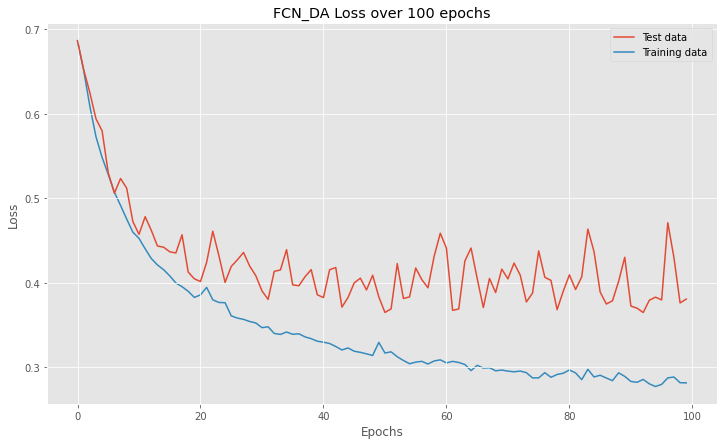

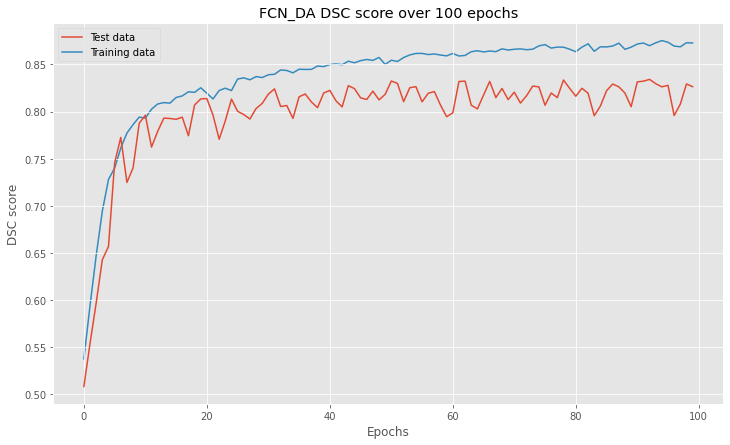

In [ ]:
model_name = "FCN_DA"
plot_result("Loss", train_losses, test_losses, model_name, learning_rate=0.001, num_epochs=100, optim="adam", batch_size=32, save_folder=folder)
plot_result("DSC score", train_scores, test_scores, model_name, learning_rate=0.001, num_epochs=100, optim="adam", batch_size=32, save_folder=folder)

In [ ]:
# Save model 
torch.save({
            'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_scores[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_scores[-1]
            }, f"{folder}/models/{model_name}")

### Hyperparameter tuning
We split the augmented training data into a new training set and validation set.

In [ ]:
def split_train_val(X, Y):

  n = X.shape[0] # Number of examples
  permutation = list(np.random.permutation(n))
  shuffled_X = X[permutation]
  shuffled_Y = Y[permutation]


  X_val = shuffled_X[:60]
  X_train = shuffled_X[60:]
  Y_val = shuffled_Y[:60]
  Y_train = shuffled_Y[60:]

  return X_train, Y_train, X_val, Y_val

In [ ]:
X_train2_numpy, Y_train2_numpy, X_val_numpy, Y_val_numpy = split_train_val(X_train_augmented, Y_train_augmented)
print(X_train2_numpy.shape, Y_train2_numpy.shape, X_val_numpy.shape, Y_val_numpy.shape)

(195, 128, 128, 3) (195, 128, 128) (60, 128, 128, 3) (60, 128, 128)


And we can define an `evaluate` function to evaluate our trained model on unseen data.

In [ ]:
def evaluate(model, X_test, Y_test):
  predictions = model(X_test)
  score = compute_DSC_score(predictions, Y_test)
  return score

#### Batch size

In [ ]:
batch_sizes = [8, 16, 32, 64, 128]
train_loaders = []

for batch_size in batch_sizes:
  train_set_tmp = MyWARWICKDataset(X_train2_numpy, Y_train2_numpy)
  train_loaders.append(DataLoader(train_set_tmp, batch_size=batch_size, shuffle=True))

In [ ]:
# Test set
val_set = MyWARWICKDataset(X_val_numpy, Y_val_numpy)
X_val_tensor, Y_val_tensor = val_set[:]
X_val_tensor = X_val_tensor.to(device)
Y_val_tensor = Y_val_tensor.to(device)

We redefine our `train_model()` function to implement early stopping. For that, we introduce a parameter epsilon, which indicates the tolerance between the validation DSC score of the previous and current epoch. So for example, if we set epsilon = 0.03, then we stop the training if the absolute difference between the validation DSC score of the previous epoch and the current one is greater than 0.03.

In [ ]:
def train_model(model, loss_criterion, performance_metric, optimizer, train_loader, X_test, Y_test, val_set, num_epochs, device, epsilon=0, plot_result=False):
  train_losses = list()
  train_scores = list()
  test_losses = list()
  test_scores = list()

  for epoch in range(num_epochs):
      train_losses_epoch = list()
      train_scores_epoch = list()

      for batch in train_loader:
          x_train, y_train = batch[0].to(device), batch[1].to(device)
          
          model.zero_grad()

          # 1. Forward propagation
          output = model(x_train)

          # 2. Compute loss and score on current mini-batch
          loss = loss_criterion(output, y_train)

          train_loss = loss.item()
          train_losses_epoch.append(train_loss)
          train_score = performance_metric(output, y_train).item()
          train_scores_epoch.append(train_score)

          # 3. Backpropagation
          loss.backward()  

          # 4. Update parameters
          optimizer.step()
      
      # Train cost and score 
      train_loss = np.mean(train_losses_epoch)
      train_losses.append(train_loss)
      train_score = np.mean(train_scores_epoch)
      train_scores.append(train_score)

      # test cost and score
      with torch.no_grad():
          output = model(X_test)

          test_loss = loss_criterion(output, Y_test).item()
          test_losses.append(test_loss)
          test_score = performance_metric(output, Y_test).item()
          test_scores.append(test_score)
      
      # Early stopping
      if len(test_scores) >= 20 and abs(test_scores[-1] - test_scores[-2]) > epsilon:
        break

      # Plot intermediate results
      if plot_result and epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  loss: {train_loss:.4f}, score: {train_score:.4f}")
        if val_set:
          print(f"  val_loss: {test_loss:.4f}, val_score: {test_score:.4f}\n")
        else:
          print(f"  test_loss: {test_loss:.4f}, test_score: {test_score:.4f}\n")

        
  print(f"FINAL Epoch [{epoch + 1}/{num_epochs}]")
  print(f'  loss: {train_loss:.4f}, score: {train_score:.4f}')
  if val_set:
    print(f"  val_loss: {test_loss:.4f}, val_score: {test_score:.4f}\n")
  else:
    print(f"  test_loss: {test_loss:.4f}, test_score: {test_score:.4f}\n")

  return train_losses, train_scores, test_losses, test_scores

In [ ]:
def plot_result(metric, train_res, test_res, val_set, model_name, learning_rate, optim="adam", batch_size=32, save_folder=None):
    num_epochs = len(train_res)
    x_axis = range(num_epochs)
    plt.figure(figsize=(12,7))
    if val_set:
      plt.plot(x_axis, test_res, label="Validation data", zorder=10)
    else:
      plt.plot(x_axis, test_res, label="Test data", zorder=10)
    plt.plot(x_axis, train_res, label="Training data", zorder=0)
    plt.ylabel(metric)
    plt.xlabel("Epochs")
    plt.title(f"{model_name} {metric} over {num_epochs} epochs")
    plt.legend()
    if save_folder and val_set:
      plt.savefig(f'{save_folder}/{model_name}_{metric}_{train_res[-1]:.4f}_val_{metric}_{test_res[-1]:.4f}_ep_{num_epochs}_{optim}_lr_{learning_rate}_bs_{batch_size}.png')
    if save_folder and not val_set:
      plt.savefig(f'{save_folder}/{model_name}_{metric}_{train_res[-1]:.4f}_test_{metric}_{test_res[-1]:.4f}_ep_{num_epochs}_{optim}_lr_{learning_rate}_bs_{batch_size}.png')


Batch size =  8
Epoch [1/100]
  loss: 0.6348, score: 0.5746
  val_loss: 0.5645, val_score: 0.6584

Epoch [11/100]
  loss: 0.3796, score: 0.8216
  val_loss: 0.3789, val_score: 0.8253

Epoch [21/100]
  loss: 0.3449, score: 0.8420
  val_loss: 0.3370, val_score: 0.8476

Epoch [31/100]
  loss: 0.3175, score: 0.8529
  val_loss: 0.3257, val_score: 0.8520

Epoch [41/100]
  loss: 0.2989, score: 0.8661
  val_loss: 0.3144, val_score: 0.8556

Epoch [51/100]
  loss: 0.3004, score: 0.8632
  val_loss: 0.3100, val_score: 0.8636

Epoch [61/100]
  loss: 0.2741, score: 0.8751
  val_loss: 0.3001, val_score: 0.8634

Epoch [71/100]
  loss: 0.2738, score: 0.8747
  val_loss: 0.3096, val_score: 0.8603

Epoch [81/100]
  loss: 0.2625, score: 0.8810
  val_loss: 0.2971, val_score: 0.8677

Epoch [91/100]
  loss: 0.2638, score: 0.8798
  val_loss: 0.3045, val_score: 0.8607

FINAL Epoch [100/100]
  loss: 0.2548, score: 0.8836
  val_loss: 0.2973, val_score: 0.8670

Final score on test set: 0.8359

Batch size =  16
Epo

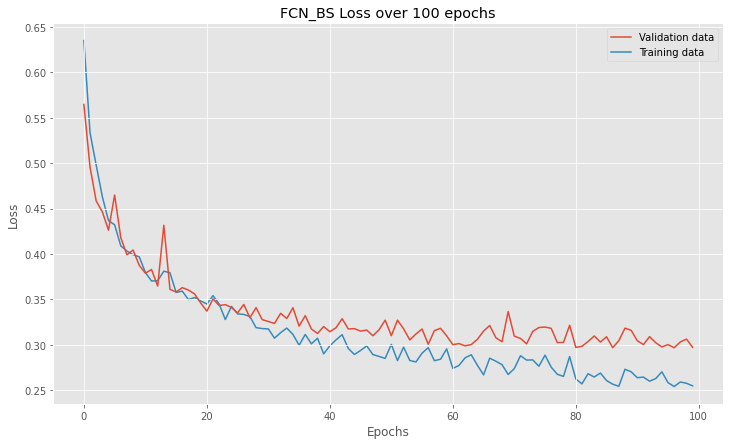

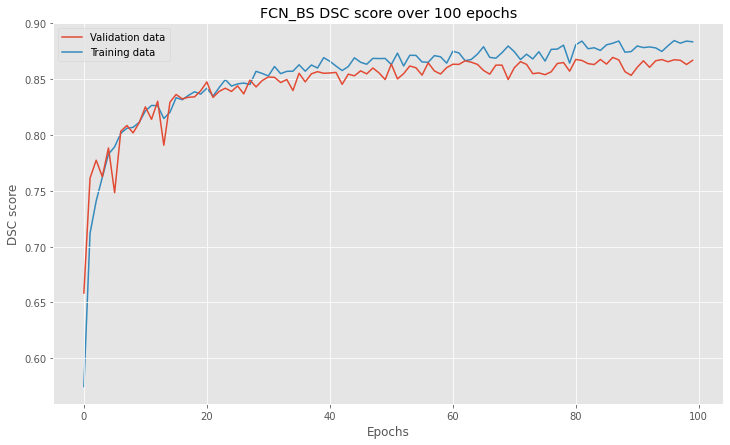

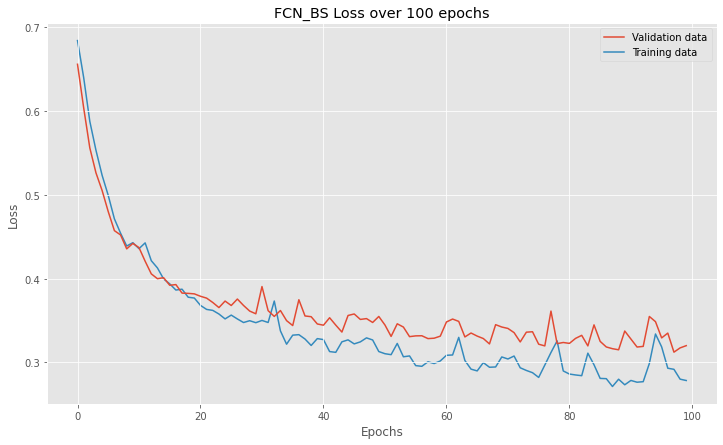

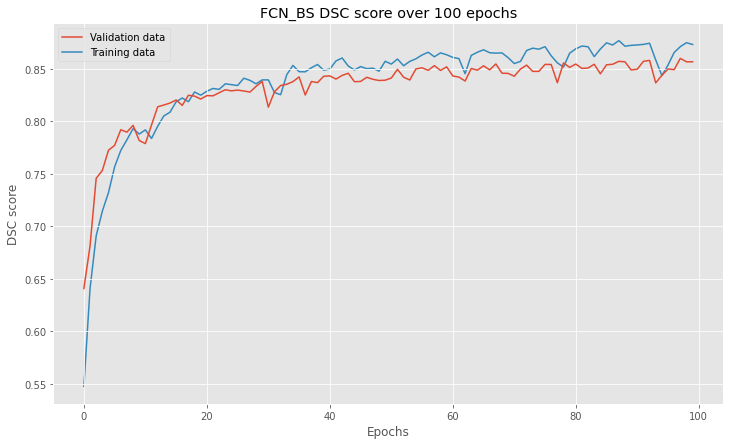

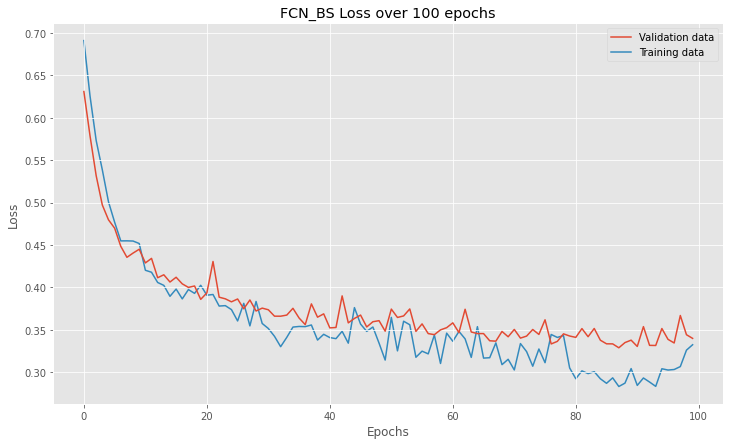

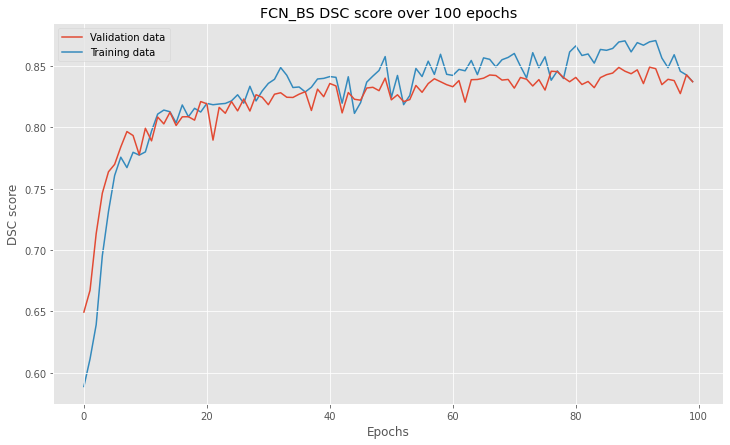

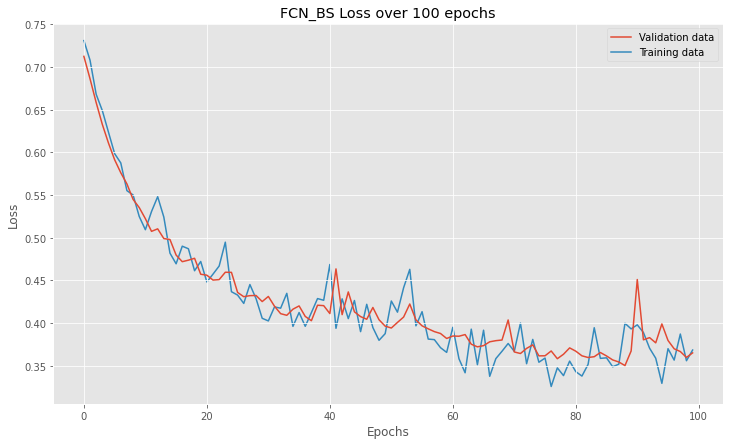

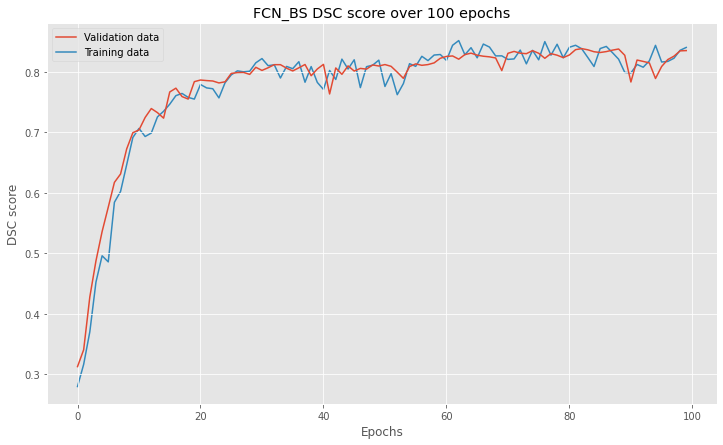

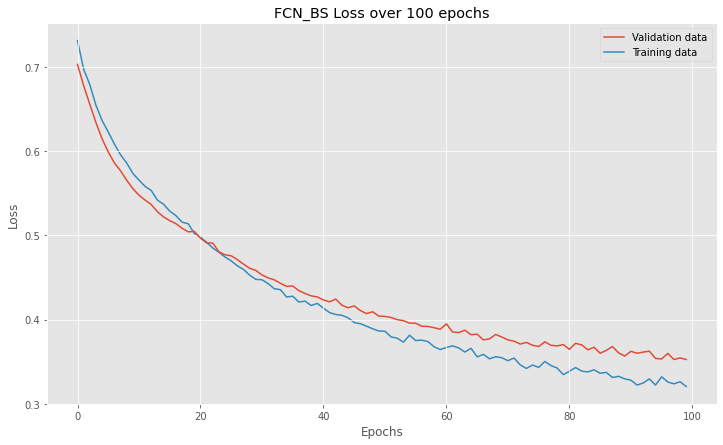

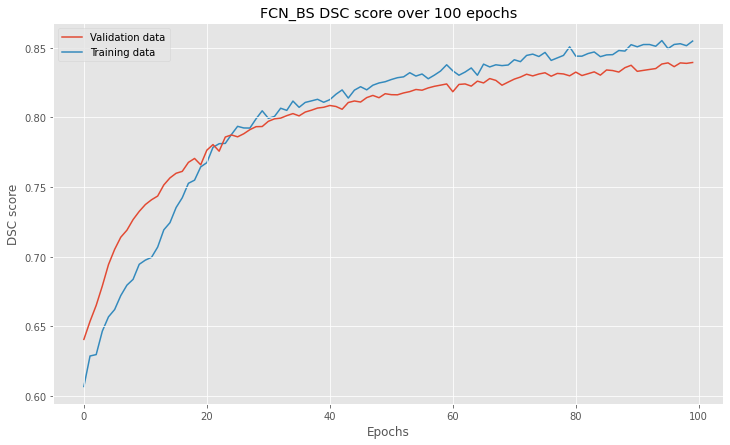

In [ ]:
model_name = "FCN_BS"
models = []
final_scores = []

for batch_size, train_loader in zip(batch_sizes, train_loaders):
  print("\nBatch size = ", batch_size)
  model = FCN2()
  loss_criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Train
  train_losses, train_scores, test_losses, test_scores = train_model(model, loss_criterion, compute_DSC_score, optimizer, train_loader, X_val_tensor, Y_val_tensor, val_set=True, num_epochs=100, epsilon = 0.03, plot_result=True)
  models.append(model)

  # Plot 
  plot_result("Loss", train_losses, test_losses, val_set=True, model_name=model_name, learning_rate=0.001, optim="adam", batch_size=batch_size, save_folder=folder)
  plot_result("DSC score", train_scores, test_scores, val_set=True, model_name=model_name, learning_rate=0.001, optim="adam", batch_size=batch_size, save_folder=folder)
  
  # Evaluate
  final_score = evaluate(model, X_test, Y_test)
  final_scores.append(final_score)
  print(f"Final score on test set: {final_score:.4f}")

We get the best result on test data when using a batch size of 8 (0.8359). But if we look closely at the DSC score plot, we can see a bit of overfitting compared to the plot for a batch size of 64. So we can choose a batch size of 64 because the model does not overfit that much and give good results on the test data.

In [ ]:
train_loader_64 = train_loaders[3]

#### Learning rate


Learning rate =  0.01
Epoch [1/100]
  loss: 0.6821, score: 0.5129
  val_loss: 0.6388, val_score: 0.4899

Epoch [11/100]
  loss: 0.4463, score: 0.7824
  val_loss: 0.4514, val_score: 0.7912

Epoch [21/100]
  loss: 0.4587, score: 0.7656
  val_loss: 0.4485, val_score: 0.7751

Epoch [31/100]
  loss: 0.3691, score: 0.8348
  val_loss: 0.3613, val_score: 0.8348

Epoch [41/100]
  loss: 0.3303, score: 0.8423
  val_loss: 0.3586, val_score: 0.8295

Epoch [51/100]
  loss: 0.3206, score: 0.8602
  val_loss: 0.3465, val_score: 0.8460

Epoch [61/100]
  loss: 0.3236, score: 0.8470
  val_loss: 0.3501, val_score: 0.8319

Epoch [71/100]
  loss: 0.2976, score: 0.8678
  val_loss: 0.3188, val_score: 0.8563

Epoch [81/100]
  loss: 0.2998, score: 0.8744
  val_loss: 0.3251, val_score: 0.8541

Epoch [91/100]
  loss: 0.3024, score: 0.8358
  val_loss: 0.3215, val_score: 0.8477

FINAL Epoch [100/100]
  loss: 0.3049, score: 0.8632
  val_loss: 0.3078, val_score: 0.8533

Final score on test set: 0.8078

Learning rate 

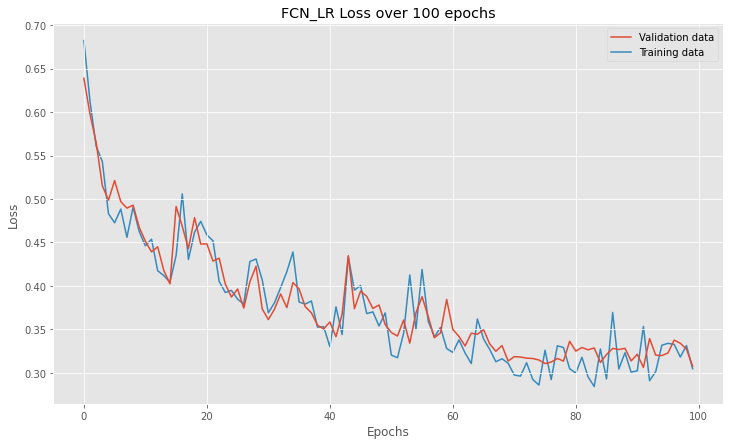

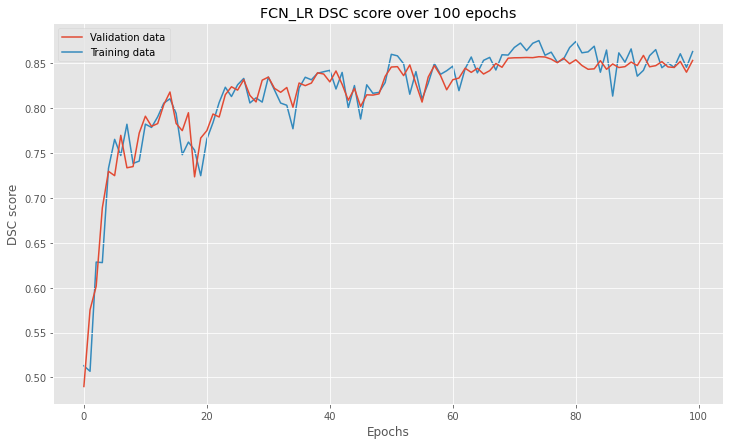

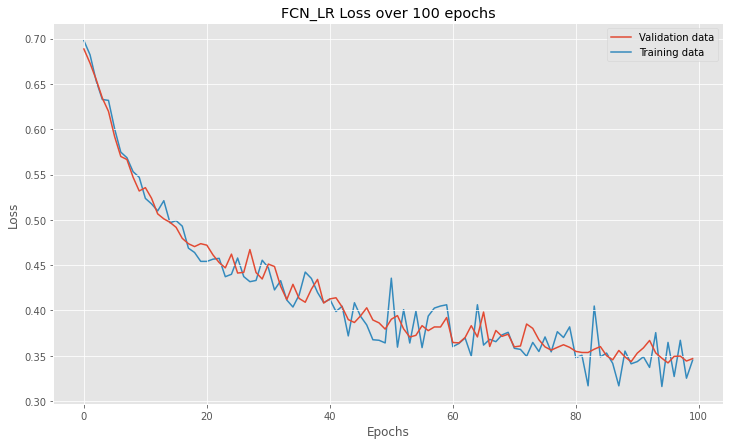

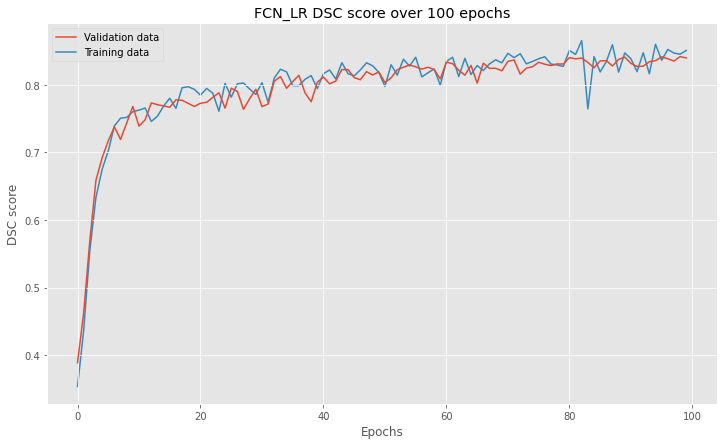

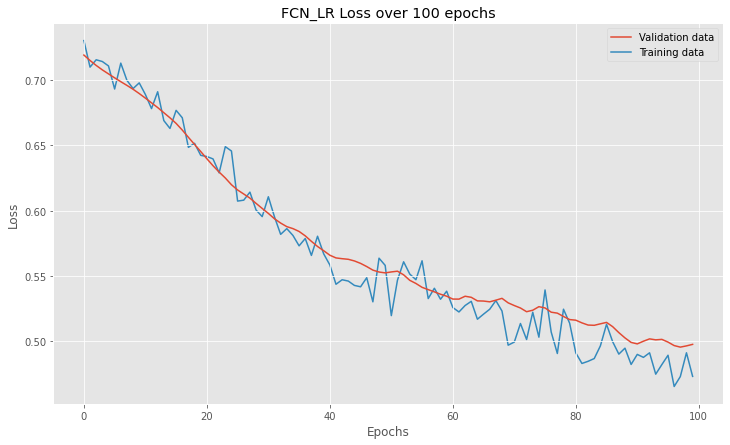

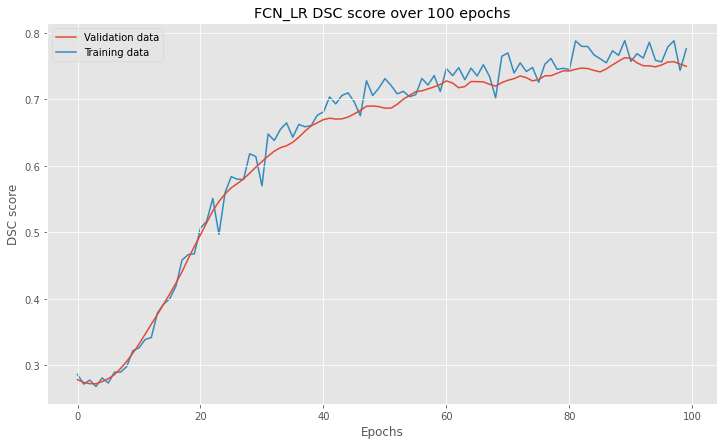

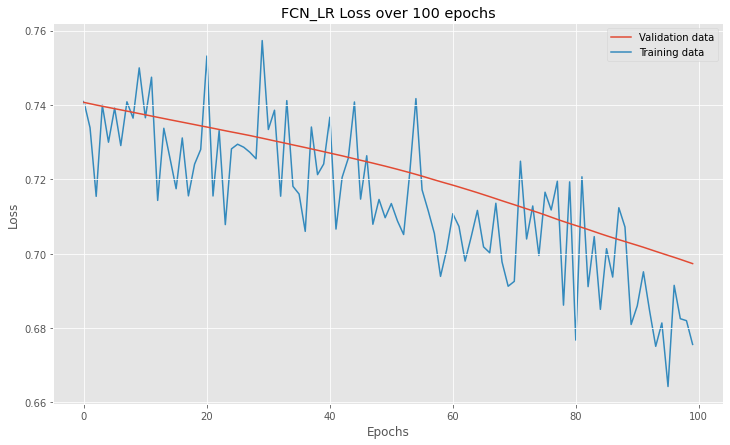

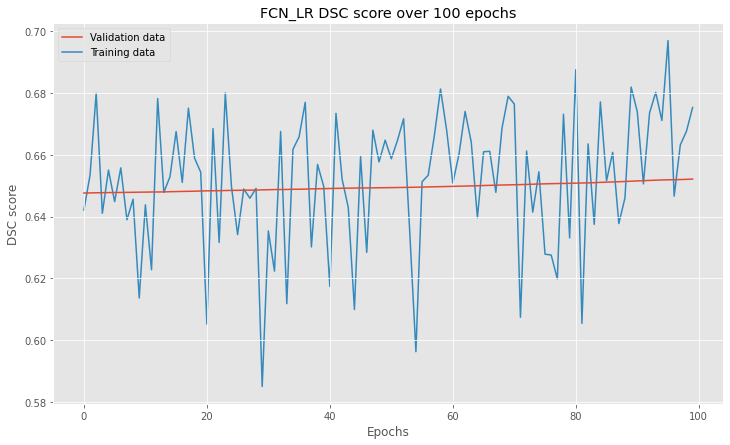

In [ ]:
model_name = "FCN_LR"
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
models = []
final_scores = []
batch_size = 64

for lr, train_loader in zip(learning_rates, train_loaders):
  print("\nLearning rate = ", lr)
  model = FCN2()
  loss_criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Train
  train_losses, train_scores, test_losses, test_scores = train_model(model, loss_criterion, compute_DSC_score, optimizer, train_loader_64, X_val_tensor, Y_val_tensor, val_set=True, num_epochs=100, epsilon = 0.03, plot_result=True)
  models.append(model)

  # Plot 
  plot_result("Loss", train_losses, test_losses, val_set=True, model_name=model_name, learning_rate=lr, optim="adam", batch_size=batch_size, save_folder=folder)
  plot_result("DSC score", train_scores, test_scores, val_set=True, model_name=model_name, learning_rate=lr, optim="adam", batch_size=batch_size, save_folder=folder)
  
  # Evaluate
  final_score = evaluate(model, X_test, Y_test)
  final_scores.append(final_score)
  print(f"Final score on test set: {final_score:.4f}")

### Best model
Batch_size = 64, learning_rate = 1e-2, and training for more epochs

Epoch [1/200]
  loss: 0.7474, score: 0.0708
  val_loss: 0.7115, val_score: 0.0712

Epoch [11/200]
  loss: 0.5199, score: 0.7628
  val_loss: 0.5426, val_score: 0.6977

Epoch [21/200]
  loss: 0.4702, score: 0.7780
  val_loss: 0.4608, val_score: 0.7814

Epoch [31/200]
  loss: 0.4324, score: 0.7802
  val_loss: 0.4223, val_score: 0.8076

Epoch [41/200]
  loss: 0.4098, score: 0.7975
  val_loss: 0.4045, val_score: 0.8136

Epoch [51/200]
  loss: 0.3646, score: 0.8306
  val_loss: 0.4019, val_score: 0.8100

Epoch [61/200]
  loss: 0.4097, score: 0.7869
  val_loss: 0.3931, val_score: 0.8075

Epoch [71/200]
  loss: 0.3513, score: 0.8395
  val_loss: 0.3826, val_score: 0.8185

Epoch [81/200]
  loss: 0.3530, score: 0.8376
  val_loss: 0.3713, val_score: 0.8303

Epoch [91/200]
  loss: 0.3382, score: 0.8508
  val_loss: 0.3792, val_score: 0.8277

Epoch [101/200]
  loss: 0.3260, score: 0.8543
  val_loss: 0.3603, val_score: 0.8353

Epoch [111/200]
  loss: 0.3329, score: 0.8441
  val_loss: 0.3633, val_score:

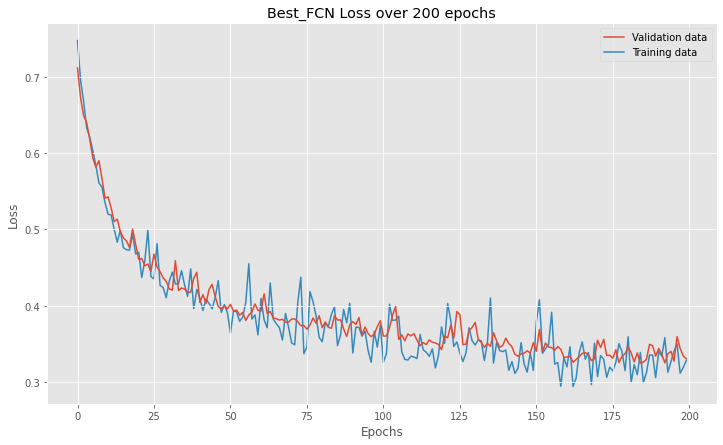

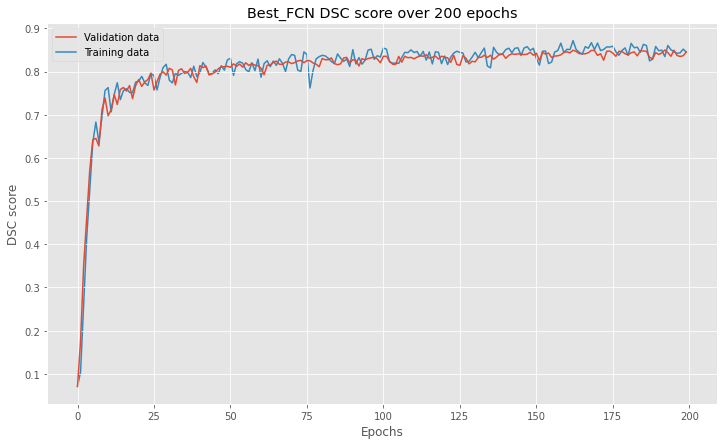

In [ ]:
### Final training 
model_name = "Best_FCN"
batch_size = 64
learning_rate = 1e-3
num_epochs = 200

best_model = FCN2()
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

# Train
train_losses, train_scores, test_losses, test_scores = train_model(best_model, loss_criterion, compute_DSC_score, optimizer, train_loader_64, X_val_tensor, Y_val_tensor, val_set=True, num_epochs=num_epochs, epsilon = 0.05, plot_result=True)

# Plot 
plot_result("Loss", train_losses, test_losses, val_set=True, model_name=model_name, learning_rate=learning_rate, optim="adam", batch_size=batch_size, save_folder=folder)
plot_result("DSC score", train_scores, test_scores, val_set=True, model_name=model_name, learning_rate=learning_rate, optim="adam", batch_size=batch_size, save_folder=folder)

# Evaluate
final_score = evaluate(best_model, X_test, Y_test)
final_scores.append(final_score)
print(f"Final score on test set: {final_score:.4f}")

In [ ]:
# Save model 
torch.save({
            'epoch': 200,
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_scores[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_scores[-1]
            }, f"{folder}/models/{model_name}")

#### Some segmentation examples

In [ ]:
# Load the model
model_name = "Best_FCN"
model = FCN2()

checkpoint = torch.load(f"{folder}/models/{model_name}")
model.load_state_dict(checkpoint['model_state_dict'])

We first visualize all the test images in `X_test`. The order is different than the order in the provided dataset.

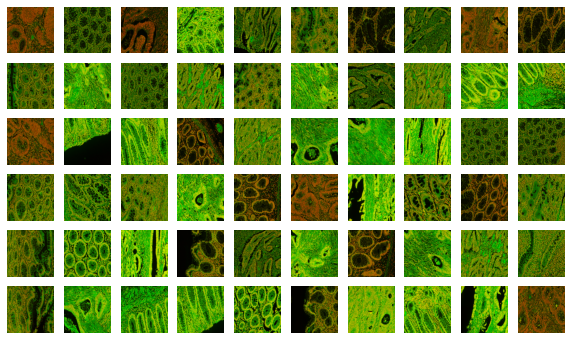

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=10, figsize=(10,6))
for i in range(6):
  for j in range(10):
    axs[i][j].imshow(X_test[i*10+j].permute(1,2,0), cmap="gray")
    axs[i][j].axis("off")

We compute the predictions of the best model on the test data.

In [ ]:
# Compute predictions of the best model
predictions = model(X_test)

We want to compare the segmentation maps obtained with the best model and the first trained network. For that, we look for the indexes in `X_test` which corresponds to the images we plotted earlier and then generate the segmentation maps.

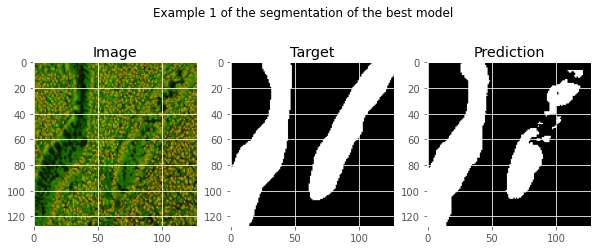

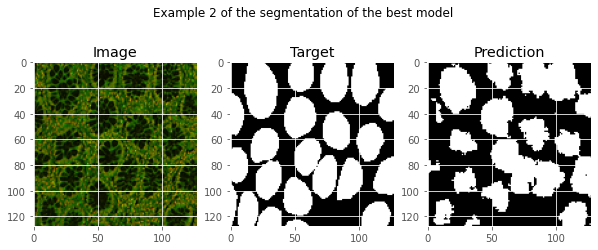

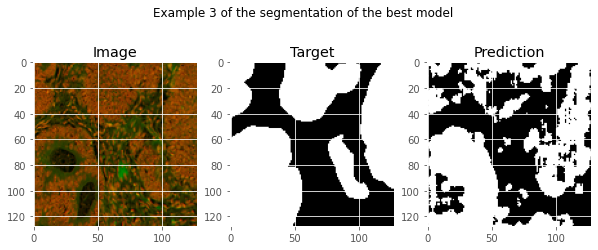

In [ ]:
idx = [49, 1, 0]
new_predictions = predictions[idx]
new_seg_map = torch.argmax(new_predictions, dim=1)
for k, i in enumerate(idx):
  images = [X_test[i].permute(1,2,0), Y_test[i], new_seg_map[k]]
  plot_images(images, f"Example {k+1} of the segmentation of the best model", f"{folder}/{model_name}_ex_{k+1}_new_segmentation.png")

We also want to plot some examples where the new network performed well and not well.

In [ ]:
scores = compute_DSC_score(predictions, Y_test, average=False)
scores

tensor([0.7732, 0.7982, 0.8431, 0.7761, 0.7684, 0.8834, 0.8651, 0.6389, 0.7063,
        0.8500, 0.8912, 0.7107, 0.7676, 0.8588, 0.8519, 0.8409, 0.7668, 0.8794,
        0.9114, 0.9394, 0.7926, 0.6290, 0.9440, 0.8966, 0.8922, 0.9275, 0.9234,
        0.7176, 0.7044, 0.7564, 0.9299, 0.9119, 0.8121, 0.8669, 0.9230, 0.7792,
        0.7749, 0.9207, 0.8744, 0.8294, 0.8787, 0.9415, 0.7832, 0.7542, 0.7071,
        0.7073, 0.9174, 0.8733, 0.8967, 0.8631, 0.9241, 0.9406, 0.9359, 0.9091,
        0.9025, 0.7205, 0.7521, 0.8426, 0.6903, 0.7368])

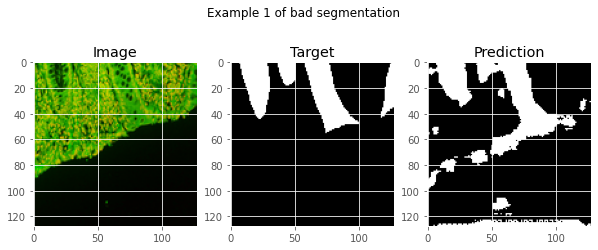

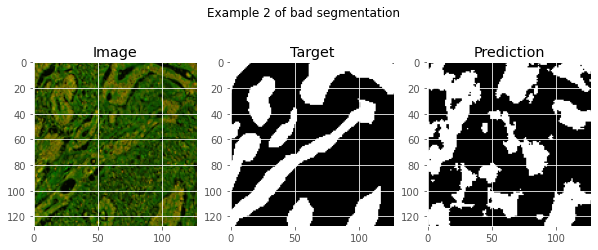

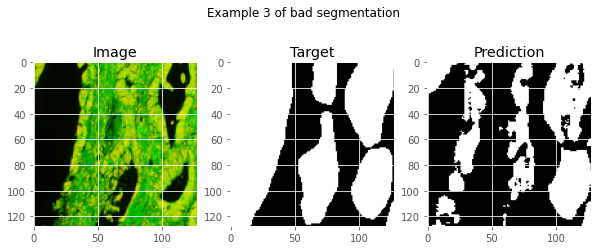

In [ ]:
smallest_k_scores, smallest_k_scores_idx = torch.topk(scores, 3, largest=False)
bad_predictions = predictions[smallest_k_scores_idx]
bad_seg_map = torch.argmax(bad_predictions, dim=1)
for k, idx in enumerate(smallest_k_scores_idx):
  images = [X_test[idx].permute(1,2,0), Y_test[idx], bad_seg_map[k]]
  plot_images(images, f"Example {k+1} of bad segmentation", f"{folder}/{model_name}_ex_{k+1}_bad_segmentation.png")

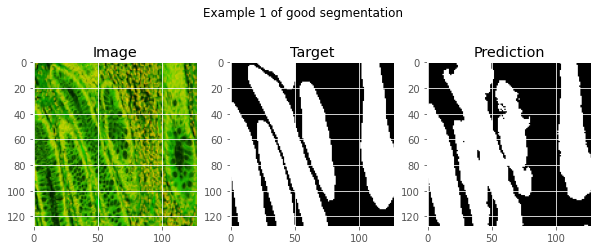

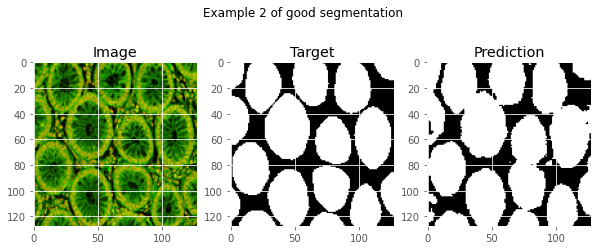

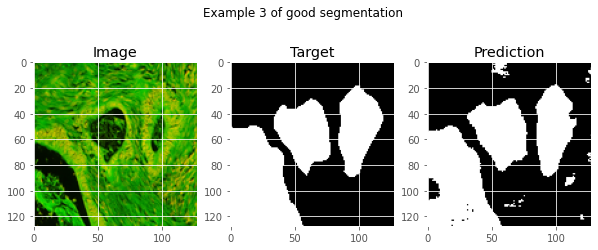

In [ ]:
largest_k_scores, largest_k_scores_idx = torch.topk(scores, 3)
good_predictions = predictions[largest_k_scores_idx]
good_seg_map = torch.argmax(good_predictions, dim=1)
for k, idx in enumerate(largest_k_scores_idx):
  images = [X_test[idx].permute(1,2,0), Y_test[idx], good_seg_map[k]]
  plot_images(images, f"Example {k+1} of good segmentation", f"{folder}/{model_name}_ex_{k+1}_good_segmentation.png")